Accessing Data From Kaggle (Fruit 360)

In [2]:
# Access google drives in colab
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
# Kaaggle API access to use the datasets in colab link
# https://stackoverflow.com/questions/49310470/using-kaggle-datasets-in-google-colab

# Install the Kaggle API client
!pip install -q kaggle

# In order to use the Kaggle API the kaggle.json file should be in the folder ~/.kaggle/
!mkdir -p ~/.kaggle
!cp 'drive/My Drive/Secure and Private AI - Udacity Facebook Scholarship - 2019/Projects/kaggle.json' ~/.kaggle/

!ls ~/.kaggle

kaggle.json


In [4]:
# Check avaialable datasets in kaggle
!kaggle datasets list

ref                                                         title                                                size  lastUpdated          downloadCount  
----------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  
bradklassen/pga-tour-20102018-data                          PGA Tour Golf Data                                   92MB  2019-08-20 10:32:59           2999  
AnalyzeBoston/crimes-in-boston                              Crimes in Boston                                     10MB  2018-09-04 17:56:03          10299  
matheusfreitag/gas-prices-in-brazil                         Gas Prices in Brazil                                  3MB  2019-07-12 16:23:52           5578  
jealousleopard/goodreadsbooks                               Goodreads-books                                     632KB  2019-06-14 16:35:05           9398  
wkirgsn/electric-motor-temperature                          Elec

Import Fruits 360 dataset from kaggle

In [5]:
import os

!mkdir 'drive/My Drive/Colab Notebooks/Fruits_360'

# copy the API command from Kaggle Fruits 360 page
!kaggle datasets download -d moltean/fruits -p 'drive/My Drive/Colab Notebooks/Fruits_360/' 

!ls 'drive/My Drive/Colab Notebooks/Fruits_360/'

100% 721M/721M [00:18<00:00, 44.1MB/s]
100% 721M/721M [00:18<00:00, 41.2MB/s]
fruits.zip


In [0]:
# unzip the dataset
!unzip -q 'drive/My Drive/Colab Notebooks/Fruits_360/fruits.zip' -d 'drive/My Drive/Colab Notebooks/Fruits_360/'

Utility Code

In [0]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

**Transfer Learning**

In [0]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

In [0]:
data_dir = 'drive/My Drive/Colab Notebooks/Fruits_360/fruits-360'

train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])
test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

train_data = datasets.ImageFolder(data_dir + '/Training', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/Test', transform=test_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64)

In [0]:
# Number of Images
print("Number of Training Images: ", len(train_data))
print("Number of Test Images: ", len(test_data))
print("Number of Fruit Classes: ", len(train_data.classes))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([64, 3, 224, 224])


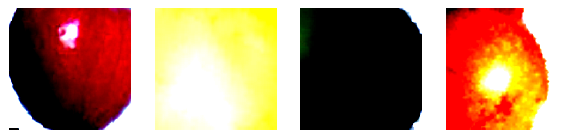

In [16]:
# Plot some of images
data_classes = train_data.classes

data_iter = iter(trainloader)
images, labels = next(data_iter)
print(images.shape)

fig, axes = plt.subplots(figsize=(10,4), ncols=4)
for ii in range(4):
  ax = axes[ii]
  ax.set_title(data_classes[labels[ii]])
  imshow(images[ii], ax=ax, normalize=False)

In [18]:
# create model
model = models.resnet101(pretrained=True)

# Use GPU if it is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for param in model.parameters():
  param.requires_grad = False

classifier = nn.Sequential(nn.Linear(2048, 512),
                           nn.ReLU(),
                           nn.Dropout(0.2),
                           nn.Linear(512, 118),
                           nn.LogSoftmax(dim=1))
model.fc = classifier

criterion = nn.NLLLoss()

# Only train the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)

model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [0]:
epochs = 12
steps = 0
running_loss = 0
print_every = 10

for e in range(epochs):
  for inputs, labels in trainloader:
    steps += 1
    # Move input and label tensors to the default device
    inputs, labels = inputs.to(device), labels.to(device)
    
    optimizer.zero_grad()
    
    log_ps = model.forward(inputs)
    loss = criterion(log_ps, labels)
    loss.backward()
    optimizer.step()
    
    running_loss += loss.item()
    
    if steps % print_every == 0:
      test_loss = 0
      accuracy = 0
      
      # Set model to evalution mode
      model.eval()
      
      with torch.no_grad():
        for inputs, labels in testloader:
          inputs, labels = inputs.to(device), labels.to(device)
          
          log_ps = model.forward(inputs)
          batch_loss = criterion(log_ps, labels)
          test_loss += batch_loss.item()
          
          ps = torch.exp(log_ps)
          top_p, top_class = ps.topk(1, dim=1)
          
          equals = top_class == labels.view(*top_class.shape)
          accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
          
      print(f"Epoch {e+1}/{epochs}.. "
            f"Train Loss: {running_loss/print_every:.3f}.. "
            f"Test Loss: {test_loss/len(testloader):.3f}.. "
            f"Accuracy: {accuracy/len(testloader):.3f}.. ")
      
      running_loss = 0
      
      # Set model back to train mode
      model.train()

Epoch 1/12.. Train Loss: 5.076.. Test Loss: 4.670.. Accuracy: 0.036.. 
Epoch 1/12.. Train Loss: 4.552.. Test Loss: 4.394.. Accuracy: 0.119.. 
Epoch 1/12.. Train Loss: 4.250.. Test Loss: 3.892.. Accuracy: 0.167.. 
Epoch 1/12.. Train Loss: 3.778.. Test Loss: 3.358.. Accuracy: 0.214.. 
Epoch 1/12.. Train Loss: 3.368.. Test Loss: 2.961.. Accuracy: 0.282.. 
Epoch 1/12.. Train Loss: 2.978.. Test Loss: 2.375.. Accuracy: 0.443.. 
Epoch 1/12.. Train Loss: 2.591.. Test Loss: 2.088.. Accuracy: 0.496.. 
Epoch 1/12.. Train Loss: 2.429.. Test Loss: 1.872.. Accuracy: 0.577.. 
Epoch 1/12.. Train Loss: 2.198.. Test Loss: 1.623.. Accuracy: 0.613.. 
Epoch 1/12.. Train Loss: 2.082.. Test Loss: 1.480.. Accuracy: 0.647.. 
Epoch 1/12.. Train Loss: 1.975.. Test Loss: 1.364.. Accuracy: 0.640.. 
Epoch 1/12.. Train Loss: 1.839.. Test Loss: 1.325.. Accuracy: 0.642.. 
Epoch 1/12.. Train Loss: 1.741.. Test Loss: 1.107.. Accuracy: 0.718.. 
Epoch 1/12.. Train Loss: 1.683.. Test Loss: 1.059.. Accuracy: 0.713.. 
Epoch 